In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
from scipy import integrate,stats
# import dabest
import os
from scipy.optimize import curve_fit

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [3]:
os.listdir()

['cip_pipeteo_dose_response_141102024.xlsx',
 'placaCIP_protocolo12tubos_dosisinicial_0.03ug-ml_M9URI_stratus2_incubdcha_151124.csv',
 'Protocolo 12 tubos.ipynb']

In [6]:
dosis_cip = pd.read_excel('cip_pipeteo_dose_response_141102024.xlsx')
# dosis_nit = pd.read_excel('nit_pipeteo_dose_response_141102024.xlsx')

In [7]:
dosis_cip

,Unnamed: 0,C (ug/ml),vi (ml),LB (ml),vf (ml)
0,1,0.0000,0.00,1.50,1.5
1,2,0.0300,1.50,0.00,1.5
2,3,0.0272,1.36,0.14,1.5
3,4,0.0244,1.22,0.28,1.5
4,5,0.0216,1.08,0.42,1.5
5,6,0.0188,0.94,0.56,1.5
6,7,0.0160,0.80,0.70,1.5
7,8,0.0132,0.66,0.84,1.5
8,9,0.0104,0.52,0.98,1.5
9,10,0.0076,0.38,1.12,1.5


In [8]:
def convertDATA(df,dosis):
    
    dosis['Unnamed: 0'] = dosis['Unnamed: 0'].astype(str)
    dic_dosis = dosis.set_index('Unnamed: 0')['C (ug/ml)'].to_dict()

    df1 = df.rename(columns={'E1':'EControl-','F1':'FControl-','G1':'GControl-','H1':'HControl-'})
    
    df1 = pd.melt(df1, id_vars=['Date and Time', 'Duration (Hours)', 'Duration (Minutes)','UNIX Timestamp', 'Air Temp '],
                     var_name='well', value_name='OD')
    
    df1['replica'] = df1['well'].str[0] #identificamos la fila del pocillo
    df1['Dosis']   = df1['well'].str[1:] #identificamos la columna del pocillo
    df1['Dosis']   = df1['Dosis'].replace(dic_dosis) #Elegimos el orden de las dosis en los pocillos

    df1 = df1.dropna()
    return df1

def visualizacionDATA(convertedDF,title=''):
    """
    Dada la tabla convertida representa graficamente los resultados
    """
    sns.lineplot(data=convertedDF, x='Duration (Hours)', y='OD', hue='Dosis',palette='mako')
    plt.title(title)
    plt.ylim(-0.05,0.6)
    plt.show()

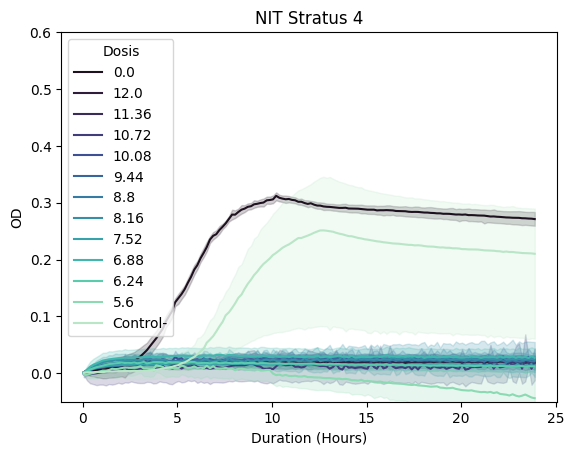

In [7]:
df_nit = pd.read_csv('placaNIT_protocolo12tubos_dosisinicial_12ug-ml_M9URI_stratus4_incubizda_151124.csv', skiprows=11)
df_nit = convertDATA(df_nit, dosis_nit)
df_nit = df_nit[df_nit['Duration (Hours)']<24]
visualizacionDATA(df_nit,title='NIT Stratus 4')

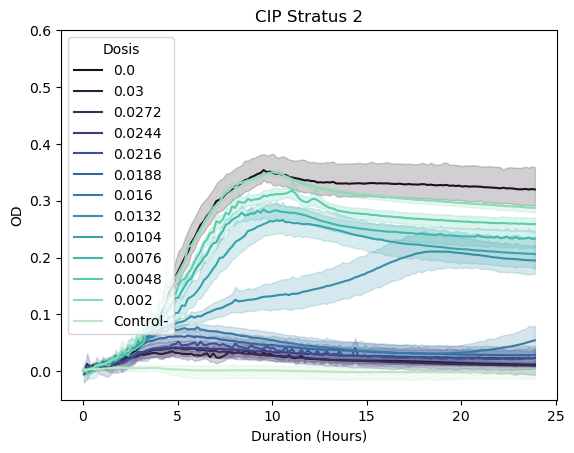

In [9]:
df_cip = pd.read_csv('placaCIP_protocolo12tubos_dosisinicial_0.03ug-ml_M9URI_stratus2_incubdcha_151124.csv', skiprows=11)
df_cip = convertDATA(df_cip, dosis_cip)
df_cip = df_cip[df_cip['Duration (Hours)']<24]
visualizacionDATA(df_cip,title='CIP Stratus 2')

In [10]:
pd.read_csv('placaCIP_protocolo12tubos_dosisinicial_0.03ug-ml_M9URI_stratus2_incubdcha_151124.csv', skiprows=11)

,Date and Time,Duration (Hours),Duration (Minutes),UNIX Timestamp,Air Temp,A1,A2,A3,A4,A5,...,H4,H5,H6,H7,H8,H9,H10,H11,H12,Unnamed: 101
0,11/15/2024 2:05 PM,0.05,3,1731675909,31.0566,-0.0020,-0.0009,-0.0018,0.0028,0.0003,...,-0.0002,0.0000,0.0005,-0.0008,0.0003,-0.0034,0.0002,0.0003,0.0012,NaN
1,11/15/2024 2:15 PM,0.22,13,1731676509,31.7559,0.0025,0.0013,-0.0037,0.0071,-0.0019,...,-0.0014,0.0016,0.0017,0.0253,0.0028,-0.0188,0.0011,0.0035,0.0025,NaN
2,11/15/2024 2:25 PM,0.38,23,1731677109,32.5762,0.0031,0.0051,-0.0030,0.0088,0.0005,...,-0.0034,0.0031,0.0036,0.0270,0.0055,0.0002,0.0039,0.0072,0.0034,NaN
3,11/15/2024 2:35 PM,0.55,33,1731677709,33.2578,0.0021,0.0068,-0.0016,0.0102,0.0033,...,-0.0058,0.0054,0.0062,0.0022,0.0081,-0.0103,0.0065,0.0110,0.0044,NaN
4,11/15/2024 2:45 PM,0.72,43,1731678309,33.7930,0.0034,0.0093,-0.0008,0.0111,0.0051,...,-0.0076,0.0072,0.0083,0.0513,0.0104,-0.0032,0.0211,0.0144,0.0051,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,11/18/2024 8:15 AM,66.23,3973,1731914155,35.3965,0.0929,-0.0064,-0.1132,0.0234,0.0474,...,-0.0054,0.2545,0.0065,0.1285,0.1575,0.1810,0.1797,0.2094,0.1402,NaN
398,11/18/2024 8:25 AM,66.40,3983,1731914755,35.3867,0.1644,-0.0063,-0.1132,0.0231,0.0473,...,-0.0053,0.2333,0.0059,0.1281,0.1572,0.1812,0.1802,0.2085,0.1403,NaN
399,11/18/2024 8:35 AM,66.56,3993,1731915355,35.3652,0.0830,-0.0062,-0.1137,0.0308,0.0472,...,-0.0053,0.2300,0.0053,0.1287,0.1579,0.1821,0.1803,0.2084,0.1398,NaN
400,11/18/2024 8:45 AM,66.73,4003,1731915955,35.3496,0.0741,-0.0062,-0.1131,0.0226,0.0477,...,-0.0060,0.2127,0.0054,0.1269,0.1585,0.1819,0.1808,0.2084,0.1394,NaN


In [13]:
df_cip

,Date and Time,Duration (Hours),Duration (Minutes),UNIX Timestamp,Air Temp,well,OD,replica,Dosis
0,11/15/2024 2:05 PM,0.05,3,1731675909,31.0566,A1,-0.0020,A,0.0
1,11/15/2024 2:15 PM,0.22,13,1731676509,31.7559,A1,0.0025,A,0.0
2,11/15/2024 2:25 PM,0.38,23,1731677109,32.5762,A1,0.0031,A,0.0
3,11/15/2024 2:35 PM,0.55,33,1731677709,33.2578,A1,0.0021,A,0.0
4,11/15/2024 2:45 PM,0.72,43,1731678309,33.7930,A1,0.0034,A,0.0
...,...,...,...,...,...,...,...,...,...
38329,11/16/2024 1:15 PM,23.22,1393,1731759325,35.5566,H12,0.2657,H,0.002
38330,11/16/2024 1:25 PM,23.39,1403,1731759925,35.5781,H12,0.2644,H,0.002
38331,11/16/2024 1:35 PM,23.56,1413,1731760525,35.5938,H12,0.2643,H,0.002
38332,11/16/2024 1:45 PM,23.72,1423,1731761125,35.6094,H12,0.2642,H,0.002


# Curvas dosis-respuesta

In [10]:
def bootstrap_median(data, n_bootstrap=1000, ci=95):
    """
    Realiza el bootstrap sobre los datos y calcula el intervalo de confianza para la mediana.
    
    :param data: numpy array con los datos
    :param n_bootstrap: número de muestras de bootstrap
    :param ci: nivel de confianza
    :return: intervalo de confianza
    """
    medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        medians.append(np.median(sample))
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    ci_lower = np.percentile(medians, lower_percentile)
    ci_upper = np.percentile(medians, upper_percentile)
    return ci_lower, ci_upper

def normal(x,mu,sigma):
    return (1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(- (x-mu)**2/(2*sigma**2))


def integrateGP(gp, xdosis, ci_l, ci_up, n=100):
    xnormal = np.linspace(ci_l,ci_up,n)
    I_values = np.zeros(n)
    for i,mu_x in enumerate(xdosis):
        mu_normal, sigma_normal = gp.predict([[mu_x]], return_std=True)
        I_values[i] = integrate.simpson(normal(xnormal, mu_normal, sigma_normal), x=xnormal)
    return I_values

def calculate_IC(df,t0,tf,plot=False, suptitle='replica_tal', saveplot=False):
    a = df[(df['Duration (Hours)'] < tf) & (df['Duration (Hours)'] > t0)].groupby(['Dosis','replica','well']).mean(numeric_only=True).reset_index()
    c = a.groupby('Dosis').median(numeric_only=True).reset_index()
    
    ci_l50, ci_up50 = bootstrap_median(a[a['Dosis']!='Control-'][a[a['Dosis']!='Control-']['Dosis']==0]['OD'].values / 2)
    ci_l70, ci_up70 = bootstrap_median(a[a['Dosis']!='Control-'][a[a['Dosis']!='Control-']['Dosis']==0]['OD'].values * 0.3)
    
    xdosis = np.linspace(0,a[a['Dosis']!='Control-']['Dosis'].max(),100)
    
    #GP
    X = a[a['Dosis']!='Control-']['Dosis'].values.reshape(-1, 1)
    Y = a[a['Dosis']!='Control-']['OD'].values
    kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gp.fit(X, Y)
    
    
    #Calculo de los IC
    I_values50 = integrateGP(gp, xdosis, ci_l50, ci_up50)
    IC50, probIC50 = xdosis[np.argmax(I_values50)], np.max(I_values50)
    
    I_values70 = integrateGP(gp, xdosis, ci_l70, ci_up70)
    IC70, probIC70 = xdosis[np.argmax(I_values70)], np.max(I_values70)
    
    if plot:
        
        
        plt.subplots(nrows=1, ncols=3, figsize=(15,4))
        plt.subplots_adjust(hspace=1)
        
        plt.subplot(1,3,1)
        plt.title('Curvas de crecimiento')
        sns.lineplot(data=df.groupby(['Duration (Hours)', 'Dosis']).median(numeric_only=True).reset_index(),
             x='Duration (Hours)', y='OD', hue='Dosis', palette='icefire')
        plt.fill_between([t0,tf],[0,0],[df['OD'].max()*1.1,df['OD'].max()*1.1],
                         alpha=0.5,color='gray',label='Final OD600')
        
        plt.subplot(1,3,2)
        plt.title('GP')
        X_new = xdosis.reshape(-1, 1)
        y_pred, sigma = gp.predict(X_new, return_std=True)
        plt.plot(X, Y, '.', markersize=10, label='exp OD', alpha=0.8, color='lightcoral')
        plt.plot(X_new, y_pred, '-', label='Predicción GP', color='black')
        plt.fill_between(X_new.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                         alpha=0.2, color='k', label='Intervalo de confianza (95%)\nsuponiendo normalidad')

        plt.fill_between([0,a[a['Dosis']!='Control-']['Dosis'].max()],[ci_l50,ci_l50] ,[ci_up50,ci_up50] , alpha=0.4, 
                         label='c.i. 95% ('+str(round(ci_l50,3))+' '+str(round(ci_up50,3))+')',
                         color='cornflowerblue',
                        )
        plt.fill_between([0,a[a['Dosis']!='Control-']['Dosis'].max()],[ci_l70,ci_l70] ,[ci_up70,ci_up70] , alpha=0.4, 
                         label='c.i. 95% ('+str(round(ci_l70,3))+' '+str(round(ci_up70,3))+')',
                         color='cornflowerblue'
                        )
        

        plt.xlabel('Dosis')
        plt.ylabel('OD t_f:['+str(t0)+', '+str(tf)+']')
        plt.legend()
        plt.ylim(0,0.4)
        
        plt.subplot(1,3,3)
        plt.title('Probabilidad de reducir el crecimiento a la mitad')
        plt.plot(xdosis,I_values50,label='IC50')
        plt.plot(xdosis,I_values70,label='IC70')
        plt.scatter(IC50,probIC50,color='red')
        plt.scatter(IC70,probIC70,color='red')
        plt.xlabel('Dosis')
        plt.ylabel('Prob')
        plt.legend()

        plt.suptitle(suptitle)
        plt.show()
    
    return [IC50, IC70], [probIC50, probIC70]

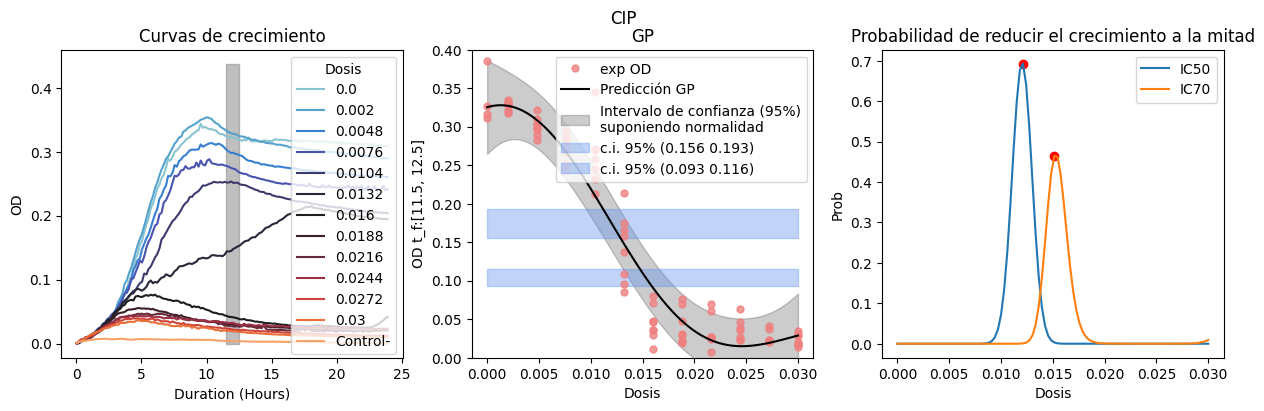

In [11]:
r = calculate_IC(df_cip,11.5,12.5,plot=True,suptitle='CIP')

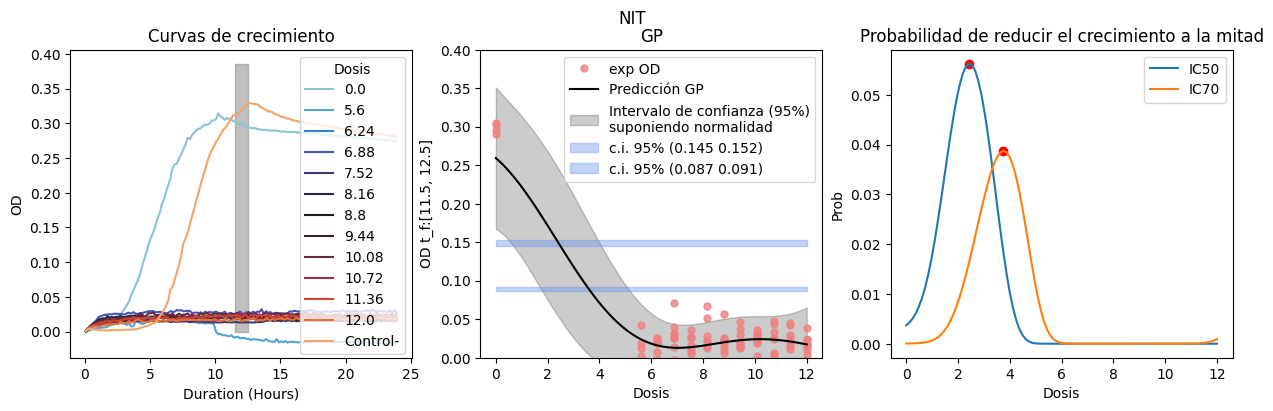

In [12]:
r = calculate_IC(df_nit,11.5,12.5,plot=True,suptitle='NIT')

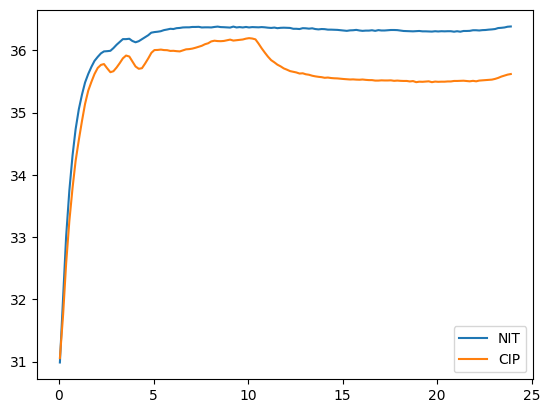

In [13]:
plt.plot(df_nit[df_nit['well']=='A1']['Duration (Hours)'], df_nit[df_nit['well']=='A1']['Air Temp '],label='NIT')
plt.plot(df_cip[df_cip['well']=='A1']['Duration (Hours)'], df_cip[df_cip['well']=='A1']['Air Temp '],label='CIP')
plt.legend()

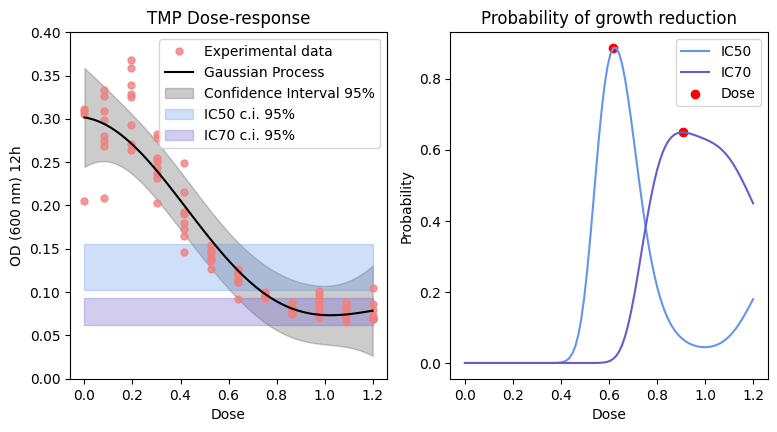

In [78]:
tf = 12.5
t0 = 11.5 

df = df_tmp

a = df[(df['Duration (Hours)'] < tf) & (df['Duration (Hours)'] > t0)].groupby(['Dosis','replica','well']).mean(numeric_only=True).reset_index()
c = a.groupby('Dosis').median(numeric_only=True).reset_index()

ci_l50, ci_up50 = bootstrap_median(a[a['Dosis']!='Control-'][a[a['Dosis']!='Control-']['Dosis']==0]['OD'].values / 2)
ci_l70, ci_up70 = bootstrap_median(a[a['Dosis']!='Control-'][a[a['Dosis']!='Control-']['Dosis']==0]['OD'].values * 0.3)

xdosis = np.linspace(0,a[a['Dosis']!='Control-']['Dosis'].max(),100)

#GP
X = a[a['Dosis']!='Control-']['Dosis'].values.reshape(-1, 1)
Y = a[a['Dosis']!='Control-']['OD'].values
kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gp.fit(X, Y)


#Calculo de los IC
I_values50 = integrateGP(gp, xdosis, ci_l50, ci_up50)
IC50, probIC50 = xdosis[np.argmax(I_values50)], np.max(I_values50)

I_values70 = integrateGP(gp, xdosis, ci_l70, ci_up70)
IC70, probIC70 = xdosis[np.argmax(I_values70)], np.max(I_values70)

plt.figure(figsize=(9,4.5))

plt.subplot(1,2,1)
plt.title('TMP Dose-response')
X_new = xdosis.reshape(-1, 1)
y_pred, sigma = gp.predict(X_new, return_std=True)
plt.plot(X, Y, '.', markersize=10, label='Experimental data', alpha=0.8, color='lightcoral')
plt.plot(X_new, y_pred, '-', label='Gaussian Process', color='black')
plt.fill_between(X_new.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                 alpha=0.2, color='k', label='Confidence Interval 95%')

plt.fill_between([0,a[a['Dosis']!='Control-']['Dosis'].max()],[ci_l50,ci_l50] ,[ci_up50,ci_up50] , alpha=0.3, 
                 label='IC50 c.i. 95%',
                 color='cornflowerblue',
                )
plt.fill_between([0,a[a['Dosis']!='Control-']['Dosis'].max()],[ci_l70,ci_l70] ,[ci_up70,ci_up70] , alpha=0.3, 
                 label='IC70 c.i. 95%',
                 color='slateblue'
                )


plt.xlabel('Dose')
plt.ylabel('OD (600 nm) 12h')
plt.legend()
plt.ylim(0,0.4)

plt.subplot(1,2,2)
plt.title('Probability of growth reduction')
plt.plot(xdosis,I_values50,label='IC50',color='cornflowerblue')
plt.plot(xdosis,I_values70,label='IC70',color='slateblue')
plt.scatter(IC50,probIC50,color='red',label='Dose')
plt.scatter(IC70,probIC70,color='red')
plt.xlabel('Dose')
plt.ylabel('Probability')
plt.legend()

plt.savefig('Dose-response TMP.png',dpi=500)
plt.show()

In [14]:
def plotStratus(df,title):
    fig, ax1 = plt.subplots()
    
    for i in ['E','F','G','H']:
        ax1.plot(df['Duration (Hours)'],df[i+'1'],c='lightcoral',label='Control -')
    for i in ['A','B','C','D']:
        ax1.plot(df['Duration (Hours)'],df[i+'1'],c='gray', label='Control +')

    ax1.plot([0,22],[0,0],'--',color='black')
    
    ax1.set_ylabel('OD(600)')
    ax1.set_xlabel('Duration (Hours)')
    ax1.set_ylim(-0.05,0.4)
    ax2 = ax1.twinx()

    ax2.plot(df['Duration (Hours)'], df['Air Temp '],'--',color='limegreen')
    ax2.set_ylabel('Air Temp', color = 'limegreen')  
    ax2.tick_params(labelcolor = 'limegreen') 
    ax2.set_ylim(30,37)

    plt.title(title)
    plt.show()

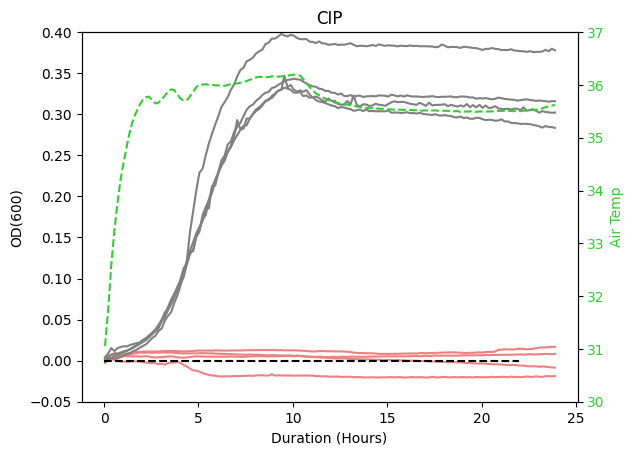

In [16]:
df_cip = pd.read_csv('placaCIP_protocolo12tubos_dosisinicial_0.03ug-ml_M9URI_stratus2_incubdcha_151124.csv', skiprows=11)
df_cip = df_cip[df_cip['Duration (Hours)']<24]
plotStratus(df_cip, 'CIP')

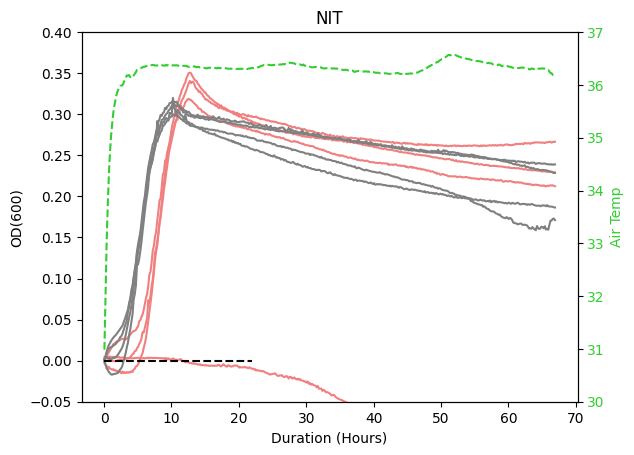

In [17]:
df_nit = pd.read_csv('placaNIT_protocolo12tubos_dosisinicial_12ug-ml_M9URI_stratus4_incubizda_151124.csv', skiprows=11)
plotStratus(df_nit, 'NIT')